## Neural Network training on GPU

* We're going to create our first ANN network that will get trained over Fashion MNIST dataset
* The dataset is a cropped out version of original version which contains approximately 60k records.

#### Arcitecture:
* Input : 784
* Hidden layer 1: 784 -> 128
* ReLU()
* Hidden layer 2: 128 -> 64
* ReLU()
* Output Layer 3: 64 -> 10
* Why not softmax in output? Well our Binary Cross Entropy already has softmax built in itself

* At first we gonna build our CustomDataset Class

In [4]:
#importing standard libraries
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.optim as optim

In [5]:
#Set manual seed for reproducibility
torch.manual_seed(42)

In [6]:
#Check for GPU
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device:{device}")

Using device:cuda


In [7]:
df=pd.read_csv('./data/fashion-mnist_train.csv')
df.head(5)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
X=df.iloc[:,1:].values
Y=df.iloc[:,:1].values
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.1,random_state=42,stratify=Y)

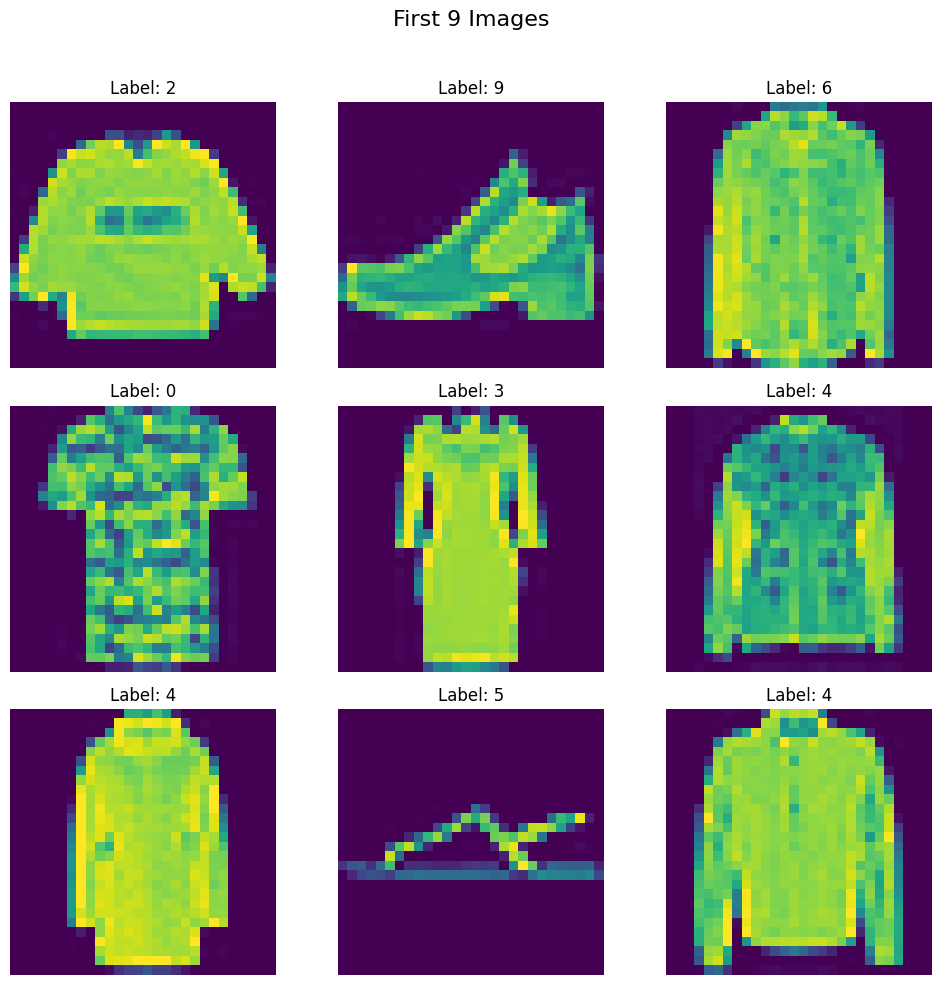

In [9]:
# Create a 4x4 grid of images
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
fig.suptitle("First 9 Images", fontsize=16)

# Plot the first 16 images from the dataset
for i, ax in enumerate(axes.flat):
    img = df.iloc[i, 1:].values.reshape(28, 28)  # Reshape to 28x28
    ax.imshow(img)  # Display in grayscale
    ax.axis('off')  # Remove axis for a cleaner look
    ax.set_title(f"Label: {df.iloc[i, 0]}")  # Show the label

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()

In [10]:
#Scaling the features
X_train=X_train/255.0
X_test=X_test/255.0

In [11]:
class CustomDataset(Dataset):
    #constructor
    def __init__(self,features,labels):
        self.features=torch.tensor(features,dtype=torch.float32)
        self.labels=torch.tensor(labels,dtype=torch.long).squeeze()  
    # Len
    def __len__(self):
        return len(self.features)
    # getitem
    def __getitem__(self, index):
        return self.features[index],self.labels[index]

In [12]:
#create train_dataset object
train_dataset=CustomDataset(X_train,Y_train)

In [13]:
train_dataset[0]

(tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0

In [14]:
#Create test dataset object
test_dataset=CustomDataset(X_test,Y_test)

In [15]:
#create train and test loader
train_loader=DataLoader(train_dataset,batch_size=128,shuffle=True,pin_memory=True) #adding pin_memory for faster training (data transfer from CPU to GPU)
test_loader=DataLoader(test_dataset,batch_size=128,shuffle=False,pin_memory=True) #adding pin_memory for faster execution

In [16]:
#define NN Architecture
class SimpleNN(nn.Module):
    def __init__(self,num_features):
        super().__init__()
        self.model=nn.Sequential(
            nn.Linear(num_features,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,10)
        )
    def forward(self,X):
        return self.model(X)

In [17]:
# Set learning rate and epochs
epochs=100
learning_rate=0.1

In [18]:
#instantiate the model
model=SimpleNN(X_train.shape[1])
model=model.to(device=device) #Move model to GPU

#loss function
criterion=nn.CrossEntropyLoss()

#optimizer
optimizer=optim.SGD(model.parameters(),lr=learning_rate)

In [19]:
#train load dataset
len(train_loader)

422

In [20]:
#training loop
for epoch in range(epochs):
    total_loss=0
    for batch_features,batch_labels in train_loader:
        batch_features,batch_labels=batch_features.to(device),batch_labels.to(device) # Move the batch data also to GPU in training loop
        #forward pass
        outputs=model(batch_features)
        #loss calculation
        loss=criterion(outputs,batch_labels)
        #backpropagation
        optimizer.zero_grad()
        loss.backward()
        #weights update
        optimizer.step()
        
        total_loss+=loss.item()
    avg_loss=total_loss/len(train_loader)
    print(f"Epoch:{epoch+1} , Loss: {avg_loss}")
        

Epoch:1 , Loss: 0.8599260950116749
Epoch:2 , Loss: 0.5135498140095535
Epoch:3 , Loss: 0.4525119901692133
Epoch:4 , Loss: 0.4159590970212814
Epoch:5 , Loss: 0.39337603366487967
Epoch:6 , Loss: 0.37389729189646753
Epoch:7 , Loss: 0.36014240644695633
Epoch:8 , Loss: 0.3451564194043101
Epoch:9 , Loss: 0.3340883495471489
Epoch:10 , Loss: 0.32301317579090877
Epoch:11 , Loss: 0.31572083496793185
Epoch:12 , Loss: 0.306931299444341
Epoch:13 , Loss: 0.29943283530773146
Epoch:14 , Loss: 0.2906946019750636
Epoch:15 , Loss: 0.28323053300239465
Epoch:16 , Loss: 0.28040854060819365
Epoch:17 , Loss: 0.27394404008066486
Epoch:18 , Loss: 0.26824481534590655
Epoch:19 , Loss: 0.2627093029248206
Epoch:20 , Loss: 0.2572528900869932
Epoch:21 , Loss: 0.25188970922435067
Epoch:22 , Loss: 0.24826556264082966
Epoch:23 , Loss: 0.24245129538020252
Epoch:24 , Loss: 0.23766636864339571
Epoch:25 , Loss: 0.2335687371156227
Epoch:26 , Loss: 0.23098302441891902
Epoch:27 , Loss: 0.22704109037515677
Epoch:28 , Loss: 0.222

### Evaluations:

In [21]:
#set model eval mode on:
model.eval()

SimpleNN(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [22]:
# evaluation code
total=0
correct=0
with torch.no_grad():
    for batch_features,batch_labels in test_loader:
        batch_features,batch_labels=batch_features.to(device),batch_labels.to(device) # Move the batch data also to GPU in evaluation code
        outputs=model(batch_features)
        _,predictions=torch.max(outputs,1)
        total=total+len(batch_labels)
        correct=correct+(predictions==batch_labels).sum().item()
print(correct/total)

0.8858333333333334


#### Slight improvement of approximately 2% test accuracy can be observed above

In [23]:
# evaluation code on training set
total=0
correct=0
with torch.no_grad():
    for batch_features,batch_labels in train_loader:
        batch_features,batch_labels=batch_features.to(device),batch_labels.to(device) # Move the batch data also to GPU in evaluation code
        outputs=model(batch_features)
        _,predictions=torch.max(outputs,1)
        total=total+len(batch_labels)
        correct=correct+(predictions==batch_labels).sum().item()
print(correct/total)

0.9737962962962963


#### We observe above the accuracy score for train dataset and the difference of that with test dataset is approximately of 10% which indicates the issue :
`Overfitting`

* Now we'll discuss about multiple optimization techniques in order to tackle this issue of overfitting.